# Domain Specific Web Scraping

#### Install & Imports 

In [ ]:
!pip -q install requests beautifulsoup4 pandas nltk seaborn tqdm lxml

#### Scrape

In [ ]:
import os
import re
import time
import json
import math
import string
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from collections import Counter
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK data
nltk.download('punkt')         # tokenizers[7][19][21]
nltk.download('stopwords')     # stopwords[7][21]
nltk.download('wordnet')       # lemmatizer data[7][10][13][16]
nltk.download('omw-1.4')       # wordnet corpora support[13]
# newer tagger names differ by version; try classic if available
try:
    nltk.download('averaged_perceptron_tagger')
except:
    pass

# ---- Parameters ----
SEED_CATEGORY = "https://en.wikipedia.org/wiki/Category:American_male_professional_wrestlers"  # broad category
BASE = "https://en.wikipedia.org"
MAX_DOCS = 320        
CRAWL_SLEEP = 0.5     # be polite to servers
TIMEOUT = 15

OUTPUT_DIR = "wrestling_corpus"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DOCS_CSV = os.path.join(OUTPUT_DIR, "wrestling_documents.csv")
DOCS_JSONL = os.path.join(OUTPUT_DIR, "wrestling_documents.jsonl")

# ---- Helpers ----

def is_wikipedia_article(url):
    # Accept main article namespace only (no File:, Help:, Category:, Talk:, etc.)
    p = urlparse(url)
    if p.netloc not in {"en.wikipedia.org"}:
        return False
    path = p.path
    if not path.startswith("/wiki/"):
        return False
    # Filter out non-article namespaces
    bad_prefixes = [
        "/wiki/File:", "/wiki/Help:", "/wiki/Talk:", "/wiki/Category:",
        "/wiki/Special:", "/wiki/Template:", "/wiki/Template_talk:",
        "/wiki/Portal:", "/wiki/Draft:", "/wiki/Module:", "/wiki/Wikipedia:",
        "/wiki/MediaWiki:", "/wiki/Book:"
    ]
    return not any(path.startswith(bp) for bp in bad_prefixes)

def get_soup(url):
    r = requests.get(url, timeout=TIMEOUT, headers={"User-Agent": "Mozilla/5.0 (edu-project)"})
    r.raise_for_status()
    return BeautifulSoup(r.text, "lxml")

def extract_title_and_text(soup):
    # Title
    title_tag = soup.find("h1", id="firstHeading")
    title = title_tag.get_text(strip=True) if title_tag else ""

    # Article content – Wikipedia stores paragraphs in div#mw-content-text
    content_div = soup.find("div", id="mw-content-text")
    text_parts = []
    if content_div:
        # Remove tables, infoboxes, navboxes, and references
        for sel in content_div.select("table, .infobox, .navbox, .vertical-navbox, .toc, .reference, .reflist, sup.reference"):
            sel.decompose()
        # Gather paragraphs
        for p in content_div.find_all(["p", "li"]):
            t = p.get_text(" ", strip=True)
            if t:
                text_parts.append(t)
    full_text = "\n".join(text_parts)
    return title, full_text

def clean_text_basic(text):
    # Replace newlines with spaces; normalize spaces
    text = text.replace("\xa0", " ").replace("\n", " ")
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def collect_category_members(category_url, limit=400):
    """
    From a Wikipedia category page, collect links to member articles (wrestlers).
    Handle pagination using 'next page'.
    """
    found = []
    next_url = category_url
    visited_pages = set()
    with tqdm(total=limit, desc="Collecting category members") as pbar:
        while next_url and len(found) < limit:
            if next_url in visited_pages:
                break
            visited_pages.add(next_url)
            try:
                soup = get_soup(next_url)
            except Exception:
                break

            # The category members are usually in div.mw-category or on category pages under div#mw-pages
            container = soup.find("div", id="mw-pages") or soup.find("div", class_="mw-category")
            if container:
                for a in container.find_all("a", href=True):
                    href = urljoin(BASE, a['href'])
                    if is_wikipedia_article(href):
                        if href not in found:
                            found.append(href)
                            pbar.update(1)
                            if len(found) >= limit:
                                break

            # Find 'next page' link for categories
            next_link = None
            for a in soup.select("a"):
                if a.get_text(strip=True).lower() in {"next page", "next 200"} and a.has_attr("href"):
                    next_link = urljoin(BASE, a['href'])
            next_url = next_link

    return found[:limit]

# ---- Task 1: Crawl and Scrape ----
def crawl_wrestlers(seed_category=SEED_CATEGORY, max_docs=MAX_DOCS):
    # Step 1: collect many wrestler article links from category
    candidate_links = collect_category_members(seed_category, limit=max_docs*2)  # over-collect to account for failures

    docs = []
    seen_urls = set()

    with tqdm(total=max_docs, desc="Scraping wrestler pages") as pbar:
        for url in candidate_links:
            if len(docs) >= max_docs:
                break
            if url in seen_urls:
                continue
            seen_urls.add(url)
            try:
                soup = get_soup(url)
                title, raw_text = extract_title_and_text(soup)
                raw_text = clean_text_basic(raw_text)
                if len(raw_text.split()) < 100:  # skip very short
                    time.sleep(CRAWL_SLEEP)
                    continue
                docs.append({
                    "url": url,
                    "title": title,
                    "content": raw_text
                })
                pbar.update(1)
                time.sleep(CRAWL_SLEEP)
            except Exception:
                time.sleep(CRAWL_SLEEP)
                continue

    # Save structured/semi-structured outputs
    df = pd.DataFrame(docs)
    df.to_csv(DOCS_CSV, index=False)
    with open(DOCS_JSONL, "w", encoding="utf-8") as f:
        for d in docs:
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

    return df

# Run crawl
df_docs = crawl_wrestlers(SEED_CATEGORY, MAX_DOCS)
print(f"Collected documents: {len(df_docs)}")
display(df_docs.head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Scraping wrestler pages: 100%|██████████| 320/320 [07:50<00:00,  1.47s/it]


Collected documents: 320


,url,title,content
0,https://en.wikipedia.org/wiki/2_Tuff_Tony,2 Tuff Tony,"Anthony Borcherding (born June 6, 1974), bette..."
1,https://en.wikipedia.org/wiki/911_(wrestler),911 (wrestler),"Alfred Poling (born January 22, 1957) is an Am..."
2,https://en.wikipedia.org/wiki/ACH_(wrestler),ACH (wrestler),"Albert Charles Hardie Jr. (born December 7, 19..."
3,https://en.wikipedia.org/wiki/A.J._%26_Big_Jus...,A.J. & Big Justice,"Andrew ""A.J."" Befumo Jr. (born January 16, 197..."
4,https://en.wikipedia.org/wiki/Tank_Abbott,Tank Abbott,"David Lee "" Tank "" Abbott (born April 26, 1965..."


####  Cleaning and Preprocessing

In [ ]:
import os
import re
import nltk
from tqdm import tqdm
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Define a user-writable directory for NLTK data
NLTK_DATA_DIR = os.path.expanduser('~/nltk_data')
os.makedirs(NLTK_DATA_DIR, exist_ok=True)

# Append to NLTK's search path if not already present
if NLTK_DATA_DIR not in nltk.data.path:
    nltk.data.path.append(NLTK_DATA_DIR)

# List of required packages (added 'punkt_tab' for newer NLTK versions)
required_packages = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']

# Download and verify each package
for package in required_packages:
    try:
        # Find the package to verify it's available
        if 'punkt' in package:
            nltk.data.find(f'tokenizers/{package}')
        else:
            nltk.data.find(f'corpora/{package}')
        print(f"NLTK package '{package}' is already available.")
    except LookupError:
        print(f"NLTK package '{package}' not found. Downloading to {NLTK_DATA_DIR}...")
        success = nltk.download(package, download_dir=NLTK_DATA_DIR, quiet=False)
        if success:
            print(f"'{package}' downloaded successfully.")
        else:
            print(f"Warning: Failed to download '{package}'. Check your internet connection or proxy settings.")

# Quick verification test for tokenizers
try:
    test_text = "This is a test sentence. And another one!"
    test_sentences = sent_tokenize(test_text)
    test_words = word_tokenize(test_text)
    print("Tokenization test successful:")
    print(f"Sentences: {test_sentences}")
    print(f"Words: {test_words}")
except LookupError as e:
    raise RuntimeError(f"Tokenization test failed: {str(e)}. Please check NLTK data paths or try manual download.")

def clean_for_nlp(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # Remove punctuation and digits
    text = re.sub(r"[^a-z\s]", " ", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Load resources after verification
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_document(text):
    # Tokenize sentences from the original text (before cleaning, to preserve punctuation for sentence boundaries)
    sentences = sent_tokenize(text)
    
    # Now clean the text for word-level processing
    cleaned = clean_for_nlp(text)
    words = word_tokenize(cleaned)
    
    # Remove stopwords and short tokens
    words = [w for w in words if w not in stop_words and len(w) > 2]
    
    # Lemmatize
    lemmas = [lemmatizer.lemmatize(w) for w in words]
    
    # Stem
    stems = [stemmer.stem(w) for w in words]
    
    return {
        "cleaned_text": cleaned,
        "tokens": words,
        "lemmas": lemmas,
        "stems": stems,
        "sentences": sentences
    }

# Apply preprocessing to entire collection
# Assumes 'df_docs' from Task 1 is in memory
preprocessed = []
for i, row in tqdm(df_docs.iterrows(), total=len(df_docs), desc="Preprocessing"):
    proc = preprocess_document(row['content'])
    preprocessed.append({
        "url": row['url'],
        "title": row['title'],
        "tokens": proc['tokens'],
        "lemmas": proc['lemmas'],
        "stems": proc['stems'],
        "sentences": proc['sentences']
    })

df_proc = pd.DataFrame(preprocessed)
print("\nPreprocessing complete. Displaying first 5 processed documents:")
display(df_proc.head())


NLTK package 'punkt' is already available.
NLTK package 'punkt_tab' not found. Downloading to C:\Users\User/nltk_data...


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to C:\Users\User/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\User/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'punkt_tab' downloaded successfully.
NLTK package 'stopwords' is already available.
NLTK package 'wordnet' not found. Downloading to C:\Users\User/nltk_data...
'wordnet' downloaded successfully.
NLTK package 'omw-1.4' not found. Downloading to C:\Users\User/nltk_data...
'omw-1.4' downloaded successfully.
Tokenization test successful:
Sentences: ['This is a test sentence.', 'And another one!']
Words: ['This', 'is', 'a', 'test', 'sentence', '.', 'And', 'another', 'one', '!']


Preprocessing: 100%|██████████| 320/320 [00:14<00:00, 22.66it/s]


Preprocessing complete. Displaying first 5 processed documents:


,url,title,tokens,lemmas,stems,sentences
0,https://en.wikipedia.org/wiki/2_Tuff_Tony,2 Tuff Tony,"[anthony, borcherding, born, june, better, kno...","[anthony, borcherding, born, june, better, kno...","[anthoni, borcherd, born, june, better, known,...","[Anthony Borcherding (born June 6, 1974), bett..."
1,https://en.wikipedia.org/wiki/911_(wrestler),911 (wrestler),"[alfred, poling, born, january, american, reti...","[alfred, poling, born, january, american, reti...","[alfr, pole, born, januari, american, retir, p...","[Alfred Poling (born January 22, 1957) is an A..."
2,https://en.wikipedia.org/wiki/ACH_(wrestler),ACH (wrestler),"[albert, charles, hardie, born, december, amer...","[albert, charles, hardie, born, december, amer...","[albert, charl, hardi, born, decemb, american,...","[Albert Charles Hardie Jr. (born December 7, 1..."
3,https://en.wikipedia.org/wiki/A.J._%26_Big_Jus...,A.J. & Big Justice,"[andrew, befumo, born, january, eric, justice,...","[andrew, befumo, born, january, eric, justice,...","[andrew, befumo, born, januari, eric, justic, ...","[Andrew ""A.J."", Befumo Jr. (born January 16, 1..."
4,https://en.wikipedia.org/wiki/Tank_Abbott,Tank Abbott,"[david, lee, tank, abbott, born, april, americ...","[david, lee, tank, abbott, born, april, americ...","[david, lee, tank, abbott, born, april, americ...","[David Lee "" Tank "" Abbott (born April 26, 196..."


#### Automatic Domain-Specific Term Extraction

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


Performing automatic domain-specific term extraction...
Calculating baseline frequencies from the Brown Corpus...


Calculating term scores: 100%|██████████| 17209/17209 [00:00<00:00, 773747.16it/s]


=== Top 30 Automatically Extracted Domain-Specific Terms ===


,Term,Specificity Score
0,wrestling,11631.982157
1,heavyweight,9905.885518
2,nwa,7054.617996
3,wwe,6043.685603
4,wrestler,5708.794687
5,championship,3310.655788
6,tag,2668.172955
7,wwf,2660.348401
8,nxt,2231.562835
9,roh,2215.913727


C:\Users\User\AppData\Local\Temp\ipykernel_29664\3414601506.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_terms, y='Term', x='Specificity Score', palette='viridis')


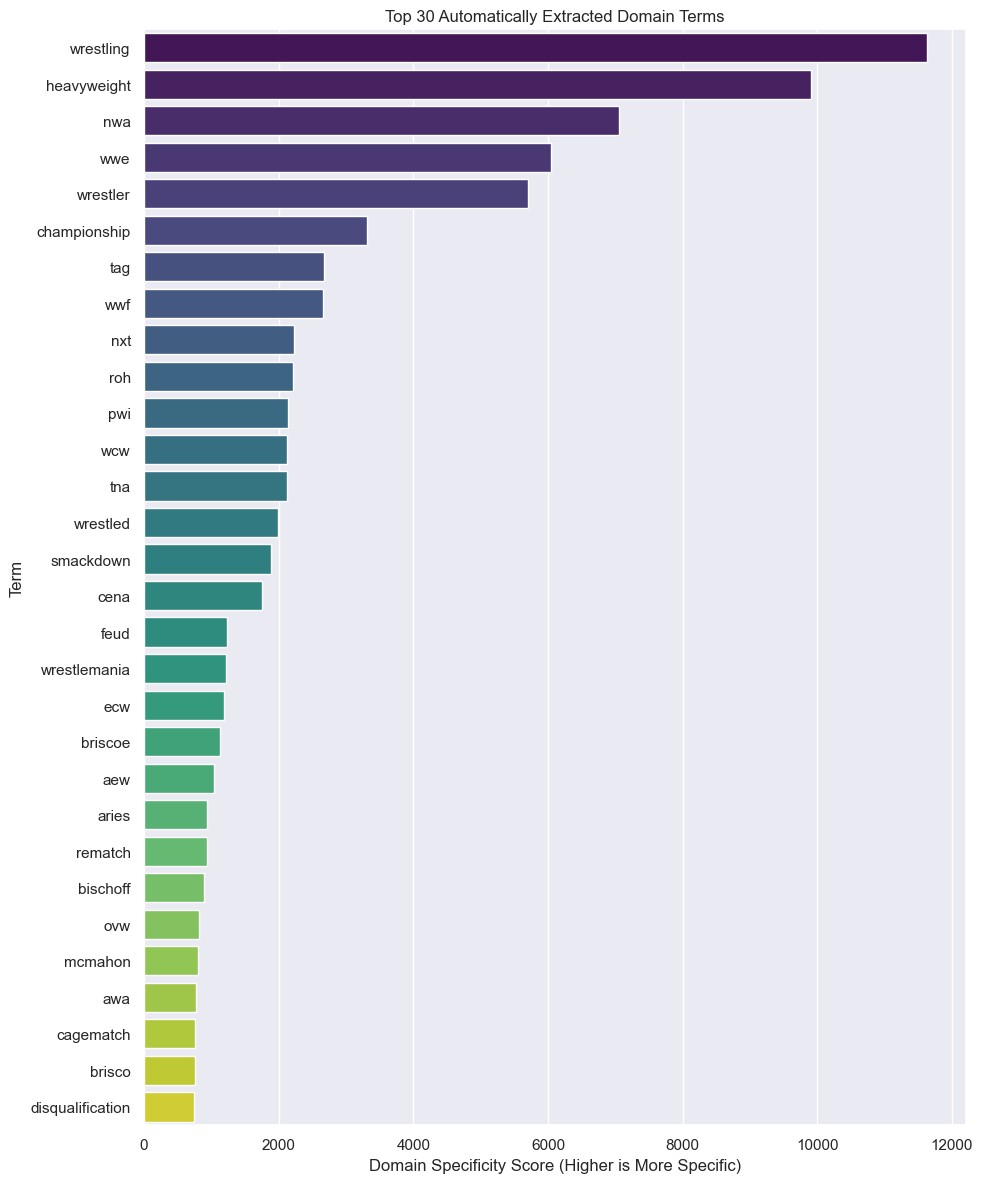

In [ ]:
import nltk
from nltk.corpus import brown
from collections import Counter

# Ensure the 'brown' corpus is downloaded
try:
    nltk.data.find('corpora/brown')
except LookupError:
    print("Downloading 'brown' corpus for baseline English frequencies...")
    nltk.download('brown')

print("Performing automatic domain-specific term extraction...")

# 1. Get word frequencies from our wrestling corpus 
all_lemmas = [w for doc in df_proc['lemmas'] for w in doc]
lemma_freq = Counter(all_lemmas)

# 2. Get baseline word frequencies from a general English corpus (Brown Corpus)
# The Brown Corpus is a balanced sample of American English texts from 1961.
print("Calculating baseline frequencies from the Brown Corpus...")
brown_words = [word.lower() for word in brown.words()]
general_english_freq = Counter(brown_words)

# Calculate total words for normalization
total_wrestling_words = sum(lemma_freq.values())
total_general_words = sum(general_english_freq.values())

# 3. Calculate a "domain-specificity" score for each word
# We will find words that are frequent in our corpus but relatively infrequent in general English.
# Score = (Wrestling Frequency / Total Wrestling Words) / (General Frequency / Total General Words)
# This is a simplified version of Pointwise Mutual Information (PMI).
term_scores = {}
for word, count in tqdm(lemma_freq.items(), desc="Calculating term scores"):
    if len(word) > 2 and word.isalpha():  # Exclude short tokens and non-alpha words
        # Get normalized frequencies
        wrestling_norm_freq = count / total_wrestling_words
        
        # Add a small smoothing value to avoid division by zero for words not in Brown Corpus
        general_norm_freq = (general_english_freq.get(word, 0) + 1) / total_general_words
        
        # The score is the ratio of the two frequencies
        score = wrestling_norm_freq / general_norm_freq
        term_scores[word] = score

# 4. Get the top N terms with the highest scores
sorted_terms = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)

print("\n=== Top 30 Automatically Extracted Domain-Specific Terms ===")
# Create a DataFrame for better display
df_top_terms = pd.DataFrame(sorted_terms[:30], columns=['Term', 'Specificity Score'])
display(df_top_terms)

# --- Visualization of Auto-Extracted Terms ---
plt.figure(figsize=(10, 12))
sns.barplot(data=df_top_terms, y='Term', x='Specificity Score', palette='viridis')
plt.title('Top 30 Automatically Extracted Domain Terms')
plt.xlabel('Domain Specificity Score (Higher is More Specific)')
plt.ylabel('Term')
plt.tight_layout()
plt.show()



#### Exploratory Data Analysis

In [ ]:
# Aggregate corpus-level lists
all_lemmas = [w for doc in df_proc['lemmas'] for w in doc]
all_tokens = [w for doc in df_proc['tokens'] for w in doc]
all_sentences = [s for doc in df_proc['sentences'] for s in doc]

# Word frequency (lemmas)
lemma_freq = Counter(all_lemmas)  # frequency distributions[11][14]
top_n = 30
top_words = lemma_freq.most_common(top_n)
top_df = pd.DataFrame(top_words, columns=["word", "freq"])

# Sentence lengths (in words) distribution
sent_lens = []
for s in all_sentences:
    # tokenize sentences into words and clean alphas
    ws = [w for w in word_tokenize(s.lower()) if w.isalpha()]
    sent_lens.append(len(ws))
sent_lens = [l for l in sent_lens if l > 0]

# Stats
avg_word_length = sum(len(w) for w in all_tokens) / max(1, len(all_tokens))
unique_words = len(set(all_lemmas))
total_words = len(all_lemmas)
lexical_diversity = unique_words / max(1, total_words)

print("=== TEXT STATISTICS (Corpus) ===")
print(f"Documents: {len(df_docs)}")
print(f"Total words (lemmas): {total_words}")
print(f"Unique words: {unique_words}")
print(f"Lexical diversity: {lexical_diversity:.4f}")
print(f"Average word length: {avg_word_length:.2f} characters")
print(f"Total sentences: {len(all_sentences)}")
print(f"Average sentence length: {sum(sent_lens)/len(sent_lens):.2f} words" if sent_lens else "No sentences found.")

# Wrestling-specific vocabulary frequency
wrestling_terms = [
    'wrestling','wrestler','champion','championship','match','title','belt','ring',
    'wwe','raw','smackdown','nxt','wrestlemania','royal','rumble','survivor','series',
    'tag','team','heel','face','promo','feud','stable','finisher','rko','pin','submission'
]
term_counts = {t: lemma_freq.get(t, 0) for t in wrestling_terms}
term_counts = {k: v for k, v in term_counts.items() if v > 0}
pd.DataFrame(sorted(term_counts.items(), key=lambda x: x[1], reverse=True), columns=["term","freq"]).head(20)


=== TEXT STATISTICS (Corpus) ===
Documents: 320
Total words (lemmas): 371009
Unique words: 17209
Lexical diversity: 0.0464
Average word length: 6.16 characters
Total sentences: 25823
Average sentence length: 22.43 words


,term,freq
0,championship,9520
1,wrestling,7433
2,team,5973
3,match,5619
4,tag,5115
5,title,2316
6,wwe,1931
7,wrestler,1824
8,champion,1603
9,ring,1354


#### Visualizations 

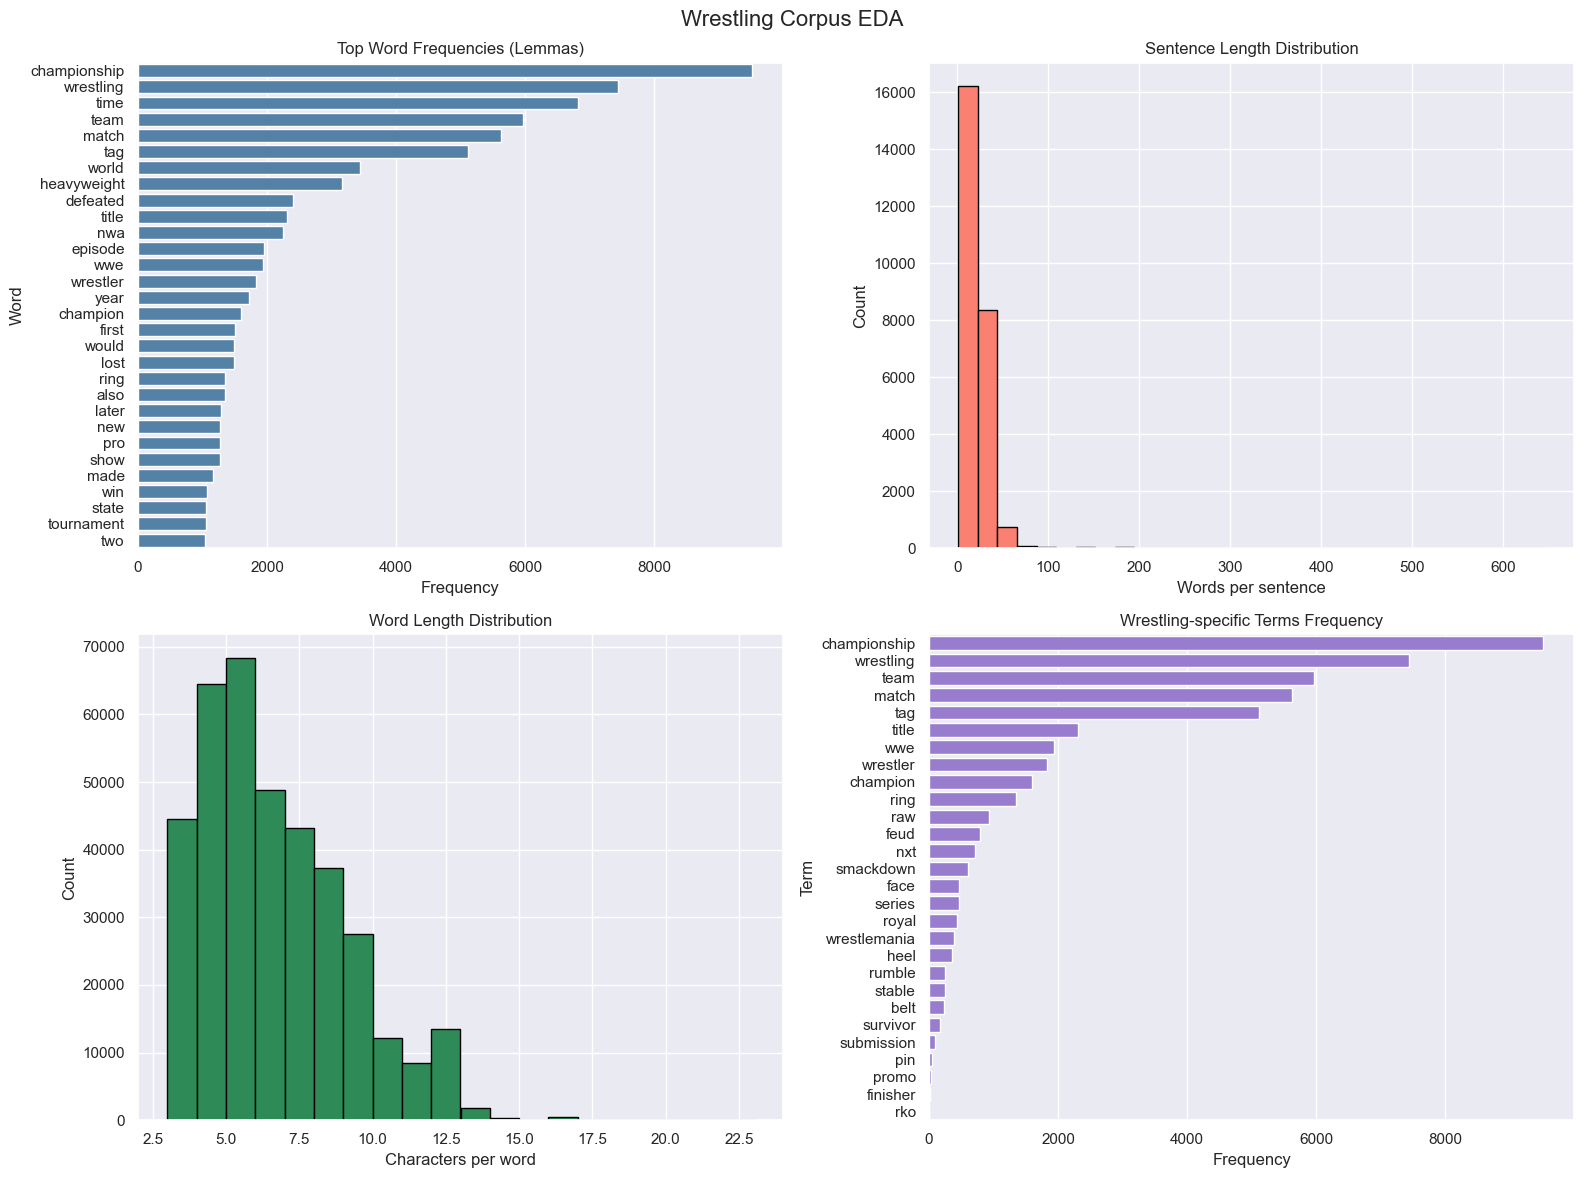

In [ ]:

plt.style.use('default')
sns.set_theme()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Wrestling Corpus EDA", fontsize=16)

# 1) Top word frequencies
sns.barplot(ax=axes[0,0], data=top_df, x="freq", y="word", color="steelblue")
axes[0,0].set_title("Top Word Frequencies (Lemmas)")
axes[0,0].set_xlabel("Frequency")
axes[0,0].set_ylabel("Word")

# 2) Sentence length distribution
axes[0,1].hist(sent_lens, bins=30, color="salmon", edgecolor="black")
axes[0,1].set_title("Sentence Length Distribution")
axes[0,1].set_xlabel("Words per sentence")
axes[0,1].set_ylabel("Count")

# 3) Word length distribution (tokens)
word_lengths = [len(w) for w in all_tokens]
axes[1,0].hist(word_lengths, bins=20, color="seagreen", edgecolor="black")
axes[1,0].set_title("Word Length Distribution")
axes[1,0].set_xlabel("Characters per word")
axes[1,0].set_ylabel("Count")

# 4) Wrestling term frequencies
if term_counts:
    tc_df = pd.DataFrame(sorted(term_counts.items(), key=lambda x: x[1], reverse=True), columns=["term","freq"])
    sns.barplot(ax=axes[1,1], data=tc_df, x="freq", y="term", color="mediumpurple")
    axes[1,1].set_title("Wrestling-specific Terms Frequency")
    axes[1,1].set_xlabel("Frequency")
    axes[1,1].set_ylabel("Term")
else:
    axes[1,1].text(0.5, 0.5, "No wrestling terms found", ha="center", va="center")
    axes[1,1].axis("off")

plt.tight_layout()
plt.show()


#### Save a cleaned corpus

In [ ]:
# Save per-document cleaned text (lemmatized tokens joined) for downstream tasks
cleaned_records = []
for i, row in df_proc.iterrows():
    cleaned_records.append({
        "url": row["url"],
        "title": row["title"],
        "cleaned_text": " ".join(row["lemmas"])
    })

df_cleaned = pd.DataFrame(cleaned_records)
CLEANED_CSV = os.path.join(OUTPUT_DIR, "wrestling_documents_cleaned.csv")
df_cleaned.to_csv(CLEANED_CSV, index=False)
print(f"Saved cleaned corpus to: {CLEANED_CSV}")
